In [1]:
from utils import *
features = ['HW', 'CIN', 'COUT', 'KERNEL_SIZE', 'STRIDES']
lut_configs = pd.read_csv('./configs/vae_inputs_patch_lut.csv')
lut_configs_train = lut_configs[lut_configs['CAT'] == 'train'][features + ['SCALED_FREQ']]
lut_configs_test = lut_configs[lut_configs['CAT'] == 'test'][features + ['SCALED_FREQ']]
df = lut_configs[features].copy()
df['HW'] = np.log2(df['HW'])
df['CIN'] = np.log2(df['CIN'])
df['COUT'] = np.log2(df['COUT'])
data = df.to_numpy().astype(np.float32)
min_val = data.min(axis=0)
max_val = data.max(axis=0)
data = (data - min_val) / (max_val - min_val)
scale = max_val - min_val

In [2]:
data = np.hstack((data, lut_configs[['SCALED_FREQ']].astype(np.float32)))
data_train = data[lut_configs['CAT'] == 'train']
data_val = data[lut_configs['CAT'] == 'test']

In [10]:

vae_path = './checkpoint/vae_ep20.model'
model = load_vae_model(vae_path)


In [4]:
x_hat_vae = generate_data(model,scale,min_val,features,3000)
x_hat_vae = reconstraint_data(x_hat_vae)

In [12]:
with open('./result/generate_config.csv', 'w') as f:
    f.write(x_hat_vae.to_csv(line_terminator='\n', index=None))

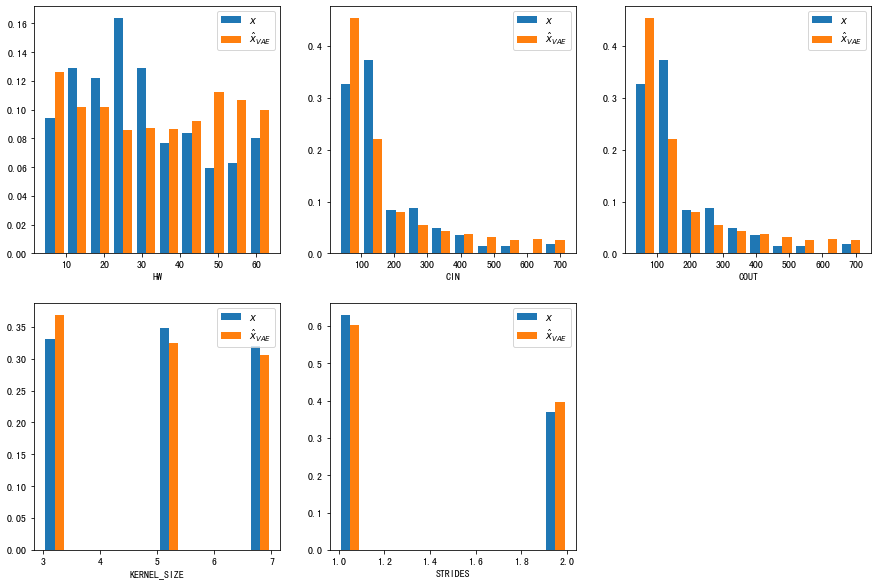

In [6]:
lut_configs_train = lut_configs_train.reset_index(drop=True)
lut_configs_train_shuffled = lut_configs_train.iloc[np.random.permutation(len(lut_configs_train))]
lut_configs_test = lut_configs_test.reset_index(drop=True)
lut_configs_test_shuffled = lut_configs_test.iloc[np.random.permutation(len(lut_configs_test))]

configs = [lut_configs_test_shuffled, x_hat_vae]
weights = [x['SCALED_FREQ'] for x in configs]
labels = ['$x$', '$\hat{x}_{VAE}$']

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    ax = plt.subplot(231 + i)
    ax.hist([x[feature] for x in configs], weights=weights, label=labels)
    ax.set_xlabel(feature)
    ax.legend()

In [7]:
kl_labels = [
    calc_self_divergence(lut_configs_train_shuffled),
    calc_self_divergence(lut_configs_test_shuffled),
    calc_divergence(lut_configs_train_shuffled, lut_configs_test_shuffled),
    calc_divergence(lut_configs_test_shuffled, lut_configs_train_shuffled),
]
print(f'KL(x_train, x_train) = {kl_labels[0]}')
print(f'KL(x_test, x_test) = {kl_labels[1]}')
print(f'KL(x_train, x_test) = {kl_labels[2]}')
print(f'KL(x_test, x_train) = {kl_labels[3]}')

KL(x_train, x_train) = 0.02330054130813768
KL(x_test, x_test) = 0.030824848282530872
KL(x_train, x_test) = 0.03725512646231534
KL(x_test, x_train) = 0.02498368169076574


In [8]:
calc_divergence(lut_configs_test_shuffled, x_hat_vae)

0.01245545875678614

In [9]:
calc_divergence(x_hat_vae, lut_configs_test_shuffled)

0.03671349079881694